# Applied Big Data Analytics in Finance

*By Daniel Deutsch, José Lucas Barretto, Karim Jaber and Ziyad Bekkaoui*

In [2]:
import glob
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import quantstats as qs

In [3]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 7),
    'axes.prop_cycle': plt.cycler(color=['#4C72B0', '#C44E52', '#55A868', '#8172B2', '#CCB974', '#64B5CD']),
    'axes.facecolor': '#EAEAF2'
})

# Data Import

At this stage, the only goal is to be able to import all the datasets into our code in the form of pandas dataframes.

## OHLCV

For each file provided by the professor, concatenates the given values into one single dataframe.

In [4]:
if os.path.exists("./datasets/ohlcv.csv.gz"):
    df_ohlcv = pd.read_csv("./datasets/ohlcv.csv.gz", index_col=0, )
else:
    df_ohlcv = pd.DataFrame()
    for filename in glob.glob("./datasets/ohlcv/*.xlsx"):
        try:
            df_tmp = pd.read_excel(
                filename, 
                usecols=[4, 6, 9, 10], 
                names=['', '', '', '', 'date', '', 'price', '', '', 'market_cap', 'volume'],
            )
            df_tmp['slug'] = filename
            df_ohlcv = pd.concat([df_ohlcv, df_tmp], ignore_index=True)
        except Exception:
            pass
    df_ohlcv.to_csv("./datasets/ohlcv.csv.gz")

## Crypto currencies Map

Obtains information over the cryptocurrencies map of each coin through the Coin Market Cap API.

In [5]:
# Makes the http request
url = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/map"
headers = {
    'Accepts': "application/json", 
    'X-CMC_PRO_API_KEY': "1a073c3f-c968-40d8-9dcf-0340a3bd5796"
}
r = requests.get(url, headers=headers)
r = r.json()

# Creates a dataframe out of the response
df_cryptomap = pd.DataFrame(r['data'])

## Sentiment

Loads the sentiment dataset provided by the professor.

In [6]:
df_sentiment = pd.read_csv("./datasets/sentiment.csv.gz", index_col=0)

## Risk-Free Rate

As the provided article uses the one-month Treasury bill rate as the risk-free rate, we import from FRED the [Market Yield on U.S. Treasury Securities at 1-Month Constant Maturity](https://fred.stlouisfed.org/series/DGS1MO).

In [7]:
df_rfr = pd.read_csv("./datasets/risk_free_rate.csv.gz")

# Data Processing

Here, the idea is to process the imported data into a format that is easier for us to interpret and manipulate it.

## OHLCV

In [8]:
# Changes columns dtypes
df_ohlcv['date'] = pd.to_datetime(df_ohlcv['date'])

# Keeps only first sample of duplicated rows
df_ohlcv.drop_duplicates(subset=['slug', 'date'], keep='first', inplace=True)

## Cryptocurrencies Map

In [9]:
# Keeps only useful columns
df_cryptomap = df_cryptomap[['symbol', 'slug', 'first_historical_data']]

# Transforms first_historical_data column dtype
df_cryptomap['first_historical_data'] = pd.to_datetime(df_cryptomap['first_historical_data']).dt.date.astype('datetime64')

## Sentiment

In [10]:
# Drop incomplete rows
df_sentiment.dropna(inplace=True)

# Represents bearish sentiment with -1 (instead of 0) 
df_sentiment['sentiment'] = df_sentiment['sentiment'].replace(0, -1)

# Renames the ticker to match CoinMarketCap symbol names
df_sentiment['ticker'] = df_sentiment['ticker'].apply(lambda ticker: ticker[:-2])
df_sentiment.rename(columns={'ticker': 'symbol'}, inplace=True)

# Obtains the average sentiment of each coin per day
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])
df_sentiment = df_sentiment.set_index('date').groupby('symbol').resample('1d').mean().reset_index()

## Risk-Free Rate

In [11]:
# Renames the columns
df_rfr.rename(columns={'DATE': 'date', 'DGS1MO': 'rfr'}, inplace=True)

# Transforms date column dtype
df_rfr['date'] = pd.to_datetime(df_rfr['date'])

# Replaces '.' with 0 
df_rfr['rfr'] = df_rfr['rfr'].replace('.', '0')

## Dataframes Merge

In [12]:
# Merges ohlcv and cryptomap dataframes
df = pd.merge(df_ohlcv, df_cryptomap, on=['slug'], how='inner')

# Merges the previously merged dataframe with the sentiment one
df = pd.merge(df_sentiment, df, on=['date', 'symbol'], how='inner')

# Merges the previously merged dataframe with the risk-free rate one
df = pd.merge(df_rfr, df, on=['date'], how='inner')

# As some of the coins change their names/slugs over time but keep their symbol,
# there will be duplicated rows in the dataset.
# Keeps only first sample of duplicated rows (the most recent one)
df.drop_duplicates(subset=['symbol', 'date'], keep='first', inplace=True)

# Keeps only useful columns
df = df[['date', 'symbol', 'price', 'volume', 'market_cap', 'sentiment', 'first_historical_data', 'rfr']]

## Data Filtering

In this project we intend to only consider coins with market capitalization above $1,000,000 on the last date and price above $0.001 on all dates. Also, we decided to remove coins that have a number of observations below 730 (two years).

In [13]:
# Removes coins with market capitalization below 1M dollars
# df = df.sort_values('date', ascending=True).groupby('symbol').filter(lambda x: x['market_cap'].iloc[-1] > 1E6)
df = df[df.market_cap > 1E6]

# Removes coins with prices below $0.01
df = df[df.price > 0.01]

# Removes coins with less than 730 observations
df = df.groupby('symbol').filter(lambda x: len(x) > 730)

## Multi-Level Dataframe

In [14]:
# Transforms the dataframe into a multi-level column dataframe
df = df.set_index(['symbol', 'date']).stack().unstack('date').T

# Changes columns dtypes
df = df.apply(pd.to_numeric, errors='ignore')
df.loc(axis=1)[:, 'first_historical_data'] = df.loc(axis=1)[:, 'first_historical_data'].apply(pd.to_datetime)

# Fill the dataframe with missing dates
df = df.asfreq('D')

# Sorts the rows in ascending order of dates
df.sort_index(inplace=True)

# resamples dataframe to weekly
df_daily = df.copy()

# Deletes previous dataframes from memory
# del df_ohlcv
# del df_cryptomap
# del df_sentiment
# del df_rfr

# Data Enhancing

Once the data is in the right shape/format, we are able to obtain more useful information for our analysis through its manipulation.

In [15]:
for i, s in enumerate(df.columns.levels[0]):

    print(f"\rsymbol={s}, {i+1}/{len(df.columns.levels[0])}", end="")

    # Adds temporary useful columns
    df[(s, 'portfolio_formation_week')] = ( df.index - df.index.min() ) // np.timedelta64(1, 'W')
    df[(s, 'r')] = df[(s, 'price')].pct_change()
    df[(s, 'cmkt')] = df[(s, 'r')] - df[(s, 'rfr')]
    df[(s, 'r/volume')] = df[(s, 'r')] / df[(s, 'volume')]

    # Rolling OLS model Ri − Rf = αi + βi CMKT + ϵi.
    model = RollingOLS(endog=df[(s, 'price')].pct_change(), exog=sm.add_constant(df[(s, 'cmkt')]), window=365)
    beta = model.fit(params_only=True)._params[:, 1]

    # Size factors
    df[(s, 'mcap')] = np.log( df[(s, 'market_cap')].shift(1) )
    df[(s, 'prc')] = np.log( df[(s, 'price')].shift(1) )
    df[(s, 'maxdprc')] = df[s].groupby('portfolio_formation_week')['price'].transform('max')
    df[(s, 'age')] = ( df.index - df[(s, 'first_historical_data')] ) // np.timedelta64(1, 'W')

    # Momentum factors
    df[(s, 'r1')] = df[(s, 'price')].pct_change(7)
    df[(s, 'r2')] = df[(s, 'price')].pct_change(7*2)
    df[(s, 'r3')] = df[(s, 'price')].pct_change(7*3)
    df[(s, 'r4')] = df[(s, 'price')].pct_change(7*4)
    df[(s, 'r8')] = df[(s, 'price')].pct_change(7*8)
    df[(s, 'r16')] = df[(s, 'price')].pct_change(7*16)
    df[(s, 'r50')] = df[(s, 'price')].pct_change(7*50)
    df[(s, 'r100')] = df[(s, 'price')].pct_change(7*100)

    # Volume factors
    df[(s, 'vol')] = np.log( df[(s, 'volume')] )
    df[(s, 'prcvol')] = np.log( df[(s, 'price')] * df[(s, 'volume')] )
    df[(s, 'volscaled')] = np.log( df[(s, 'price')] * df[(s, 'volume')] / df[(s, 'market_cap')] )

    # Volatility factors
    df[(s, 'beta')] = beta
    df[(s, 'beta2')] = beta**2
    # df[(s, 'idiovol')] = 
    df[(s, 'retvol')] = df[s].groupby('portfolio_formation_week')['r'].transform('std')
    df[(s, 'retskew')] = df[s].groupby('portfolio_formation_week')['r'].transform('skew')
    df[(s, 'retkurt')] = df[s].groupby('portfolio_formation_week')['r'].transform(pd.DataFrame.kurtosis)
    df[(s, 'maxret')] = df[s].groupby('portfolio_formation_week')['r'].transform('max')
    # df[(s, 'delay')] = 
    df[(s, 'stdprcvol')] = np.log(df[s].groupby('portfolio_formation_week')['volume'].transform('std'))
    df[(s, 'damihud')] = df[s].groupby('portfolio_formation_week')['r/volume'].transform('mean')

    # Extra factors
    df[(s, 'sentiment')] = df[(s, 'sentiment')]

    # Transforms infs into NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Removes unused columns
    # df.drop((s, 'price'), axis=1, inplace=True)
    # df.drop((s, 'volume'), axis=1, inplace=True)
    # df.drop((s, 'market_cap'), axis=1, inplace=True)
    # df.drop((s, 'first_historical_data'), axis=1, inplace=True)
    # df.drop((s, 'portfolio_formation_week'), axis=1, inplace=True)
    # df.drop((s, 'r'), axis=1, inplace=True)
    # df.drop((s, 'cmkt'), axis=1, inplace=True)
    # df.drop((s, 'r/volume'), axis=1, inplace=True)

symbol=ZRX, 135/13555

# Analysis

Now that we have all the information that we need and in the format that we want, we are able to start our analysis.

In [16]:
# Obtains a list with the considered symbols and factors
symbols = df.columns.levels[0]
factors = df.columns.levels[1]

## Portfolio Selection

In [17]:
# Initialize empty dataframe to store strategy returns
strategy_returns = pd.DataFrame(index=df.index)
strategy_returns['no_strat'] = 0
strategy_returns = strategy_returns.resample('W').last()

### Size portfolios

In [18]:
# Initialize Dataframes
factor = pd.DataFrame()
prices = pd.DataFrame()

# Store prices and factor values
for symbol in symbols:
    prices[symbol] = df[(symbol, 'price')]
    factor[symbol] = df[(symbol, 'mcap')]

# Drop dates with less than 20 observations
factor = factor.dropna(thresh=20)

# Resample factors to weekly
factor = factor.resample('W').last()

# Calculate weekly returns
weekly_returns = prices.resample('W').last().loc[factor.index].pct_change()

# Calculate returns for each quintile portfolio
portfolio_returns = pd.DataFrame()
for idx, (q1, q2) in enumerate([(0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1)]):

    # Calculate quintile bounds
    lb = factor.quantile(q1, axis=1)
    ub = factor.quantile(q2, axis=1)
    
    # Select coins in quintile
    portfolio = (1*(factor.ge(lb, axis='index') & factor.le(ub, axis='index')))

    # Calculate portfolio returns with next week's returns
    portfolio_returns[f'Q{idx+1}'] = (portfolio.shift(1)*weekly_returns).mean(axis=1)

# Store strat returns
size_returns = pd.DataFrame(portfolio_returns['Q1'] - portfolio_returns['Q5'], columns=['size_factor'])
strategy_returns = strategy_returns.merge(size_returns, right_index=True, left_index=True, how='left')

In [19]:
# Mean returns for each quintile portfolio
portfolio_returns.mean()

Q1    0.007325
Q2    0.004301
Q3    0.003396
Q4    0.002019
Q5    0.003897
dtype: float64

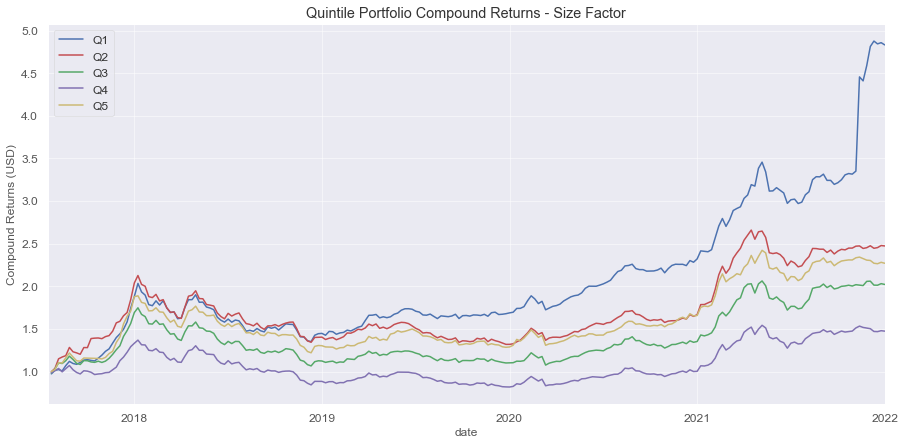

In [20]:
(1+portfolio_returns).cumprod().plot()
plt.title('Quintile Portfolio Compound Returns - Size Factor')
plt.ylabel('Compound Returns (USD)')
plt.show()

### Momentum Portfolios

In [21]:
factor = pd.DataFrame()
prices = pd.DataFrame()

for symbol in symbols:
    prices[symbol] = df[(symbol, 'price')]
    factor[symbol] = df[(symbol, 'r4')]

factor = factor.dropna(thresh=20)
factor = factor.resample('W').last()
weekly_returns = prices.resample('W').last().loc[factor.index].pct_change()

portfolio_returns = pd.DataFrame()
for idx, (q1, q2) in enumerate([(0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1)]):
    lb = factor.quantile(q1, axis=1)
    ub = factor.quantile(q2, axis=1)
    
    portfolio = (1*(factor.ge(lb, axis='index') & factor.le(ub, axis='index')))
    portfolio_returns[f'Q{idx+1}'] = (portfolio.shift(1)*weekly_returns).mean(axis=1)

momentum_returns = pd.DataFrame(portfolio_returns['Q1'] - portfolio_returns['Q5'], columns=['momentum_factor'])
strategy_returns = strategy_returns.merge(momentum_returns, right_index=True, left_index=True, how='left')

In [22]:
portfolio_returns.mean()

Q1    0.006358
Q2    0.002994
Q3    0.003836
Q4    0.003204
Q5    0.002146
dtype: float64

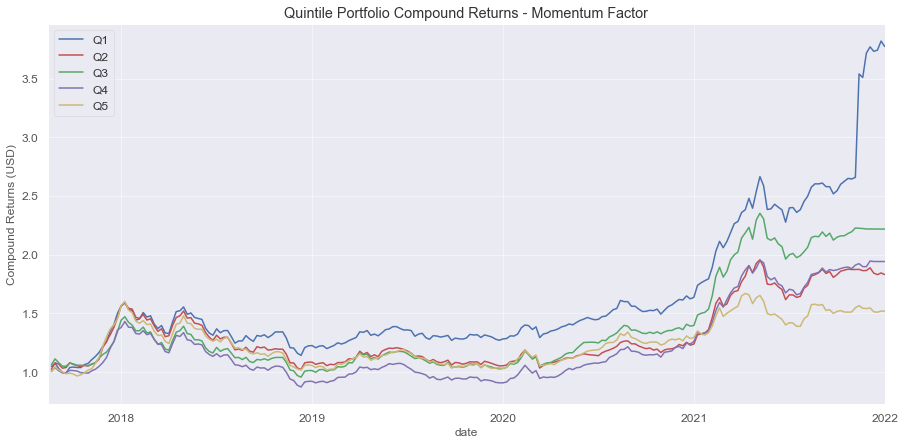

In [23]:
(1+portfolio_returns).cumprod().plot()
plt.title('Quintile Portfolio Compound Returns - Momentum Factor')
plt.ylabel('Compound Returns (USD)')
plt.show()

### Volume portfolios

In [24]:
factor = pd.DataFrame()
prices = pd.DataFrame()

for symbol in symbols:
    prices[symbol] = df[(symbol, 'price')]
    factor[symbol] = df[(symbol, 'vol')]

factor = factor.dropna(thresh=20)
factor = factor.resample('W').last()
weekly_returns = prices.resample('W').last().loc[factor.index].pct_change()

portfolio_returns = pd.DataFrame()
for idx, (q1, q2) in enumerate([(0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1)]):
    lb = factor.quantile(q1, axis=1)
    ub = factor.quantile(q2, axis=1)
    
    portfolio = (1*(factor.ge(lb, axis='index') & factor.le(ub, axis='index')))
    portfolio_returns[f'Q{idx+1}'] = (portfolio.shift(1)*weekly_returns).mean(axis=1)

volume_returns = pd.DataFrame(portfolio_returns['Q1'] - portfolio_returns['Q5'], columns=['volume_factor'])
strategy_returns = strategy_returns.merge(volume_returns, right_index=True, left_index=True, how='left')

In [25]:
portfolio_returns.mean()

Q1    0.004818
Q2    0.004484
Q3    0.005328
Q4    0.003046
Q5    0.003207
dtype: float64

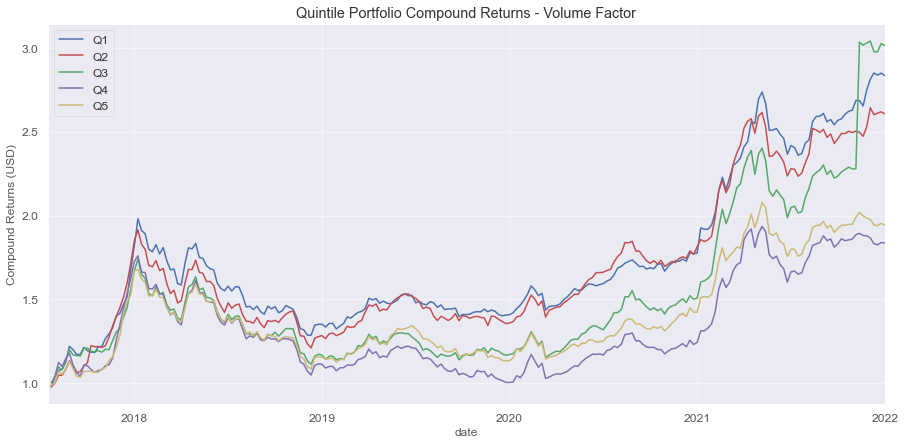

In [26]:
(1+portfolio_returns).cumprod().plot()
plt.title('Quintile Portfolio Compound Returns - Volume Factor')
plt.ylabel('Compound Returns (USD)')
plt.show()

### Volatility portfolios

In [27]:
factor = pd.DataFrame()
prices = pd.DataFrame()

for symbol in symbols:
    prices[symbol] = df[(symbol, 'price')]
    factor[symbol] = df[(symbol, 'stdprcvol')]

factor = factor.dropna(thresh=20)
factor = factor.resample('W').last()
weekly_returns = prices.resample('W').last().loc[factor.index].pct_change()

portfolio_returns = pd.DataFrame()
for idx, (q1, q2) in enumerate([(0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1)]):
    lb = factor.quantile(q1, axis=1)
    ub = factor.quantile(q2, axis=1)
    
    portfolio = (1*(factor.ge(lb, axis='index') & factor.le(ub, axis='index')))
    portfolio_returns[f'Q{idx+1}'] = (portfolio.shift(1)*weekly_returns).mean(axis=1)

volatility_returns = pd.DataFrame(portfolio_returns['Q1'] - portfolio_returns['Q5'], columns=['volatility_factor'])
strategy_returns = strategy_returns.merge(volatility_returns, right_index=True, left_index=True, how='left')

In [28]:
portfolio_returns.mean()

Q1    0.004904
Q2    0.004631
Q3    0.005968
Q4    0.002789
Q5    0.003030
dtype: float64

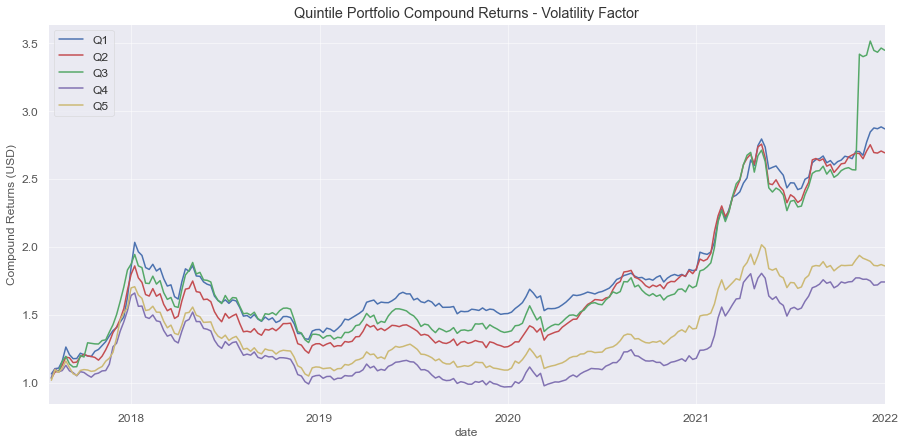

In [29]:
(1+portfolio_returns).cumprod().plot()
plt.title('Quintile Portfolio Compound Returns - Volatility Factor')
plt.ylabel('Compound Returns (USD)')
plt.show()

## Performance Measures

In [30]:
# Store strategy returns
strategy_returns = strategy_returns.fillna(0).drop(columns=['no_strat']).loc['2017-01-01':]

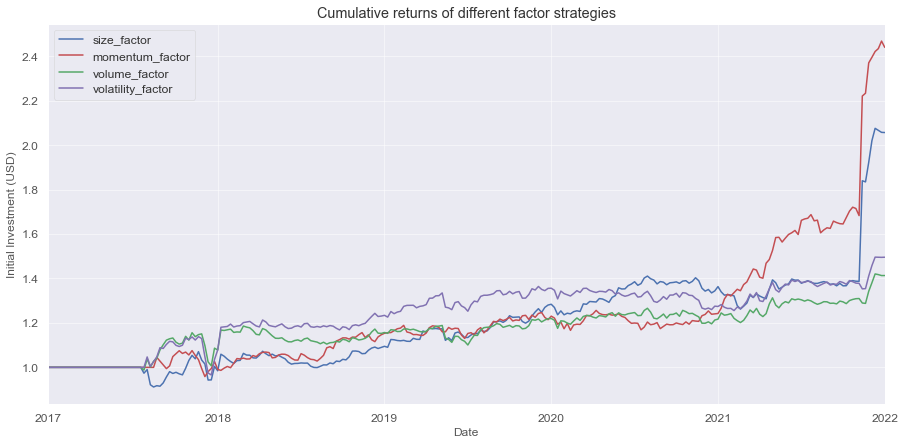

In [31]:
# Plot cumulative return for each factor strategy
(1+strategy_returns).cumprod().plot()
plt.title('Cumulative returns of different factor strategies')
plt.ylabel('Initial Investment (USD)')
plt.xlabel('Date')
plt.show()

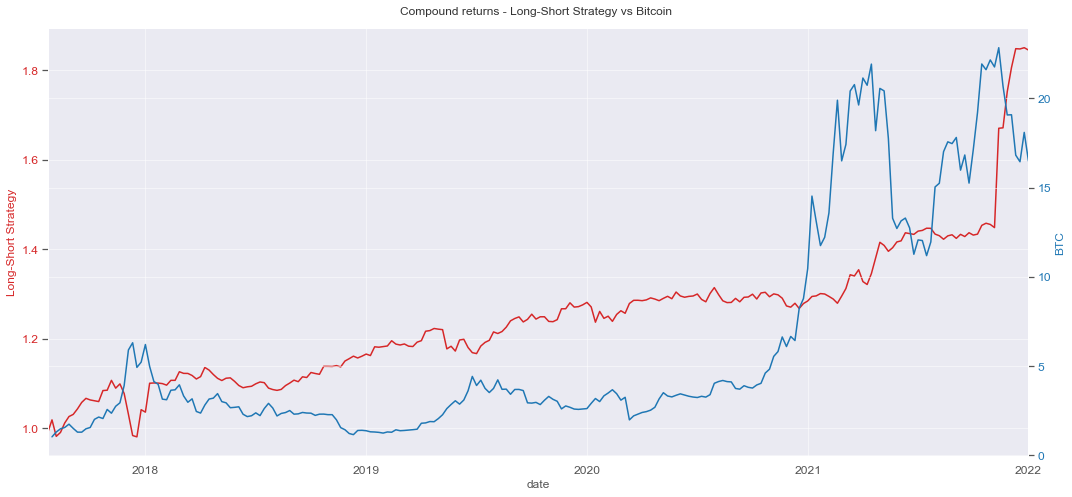

In [32]:
# Plot total strategy returns vs BTC
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_ylabel('Long-Short Strategy', color=color)
(1+strategy_returns.mean(axis=1)).cumprod().plot(color=color, ax=ax1)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_xlabel('Date')
ax2.set_ylabel('BTC', color=color)
(1 + weekly_returns['BTC']).cumprod().plot(color=color, ax=ax2)
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Compound returns - Long-Short Strategy vs Bitcoin')
fig.tight_layout()
plt.show()

In [33]:
# Run quantstats performance report
qs.reports.html(strategy_returns.mean(axis=1), weekly_returns['BTC'])